# Boston Car Crash Analysis (2015-2019)
Author: Kuncheng Fan

Date: 2019/May/13

## Introduction
Car accident is one of the most dealy reason among many reasons causing people's death. It is reported that there are  40 thousand people died in rencent years. It is meaningful and necessary to analyze the crash record to find out whether there are some paterns causing those crashes and what we should do to reduce the risk of crashes.
This project is to analyze boston crash records from Date 2015/Jan/01 to 2019/Feb/28 to firgure out what are possible factors causing car crashes and try to give advices to drivers or Boston transport department.
This project will answer the following questions:
1. Are crashes related to daytime? Does the relationship change in different months?
2. Are crashes related to temperature? Is there a trend?
3. Which streets have higher risk of crashes so that the transport department should devote more efforts to those streets?
4. How does the weather affect the risk of crashes? What should drives to be carefull about?
5. The 60 days forecast of number of crashes?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
##############Self-Defined Functions ----Start Line-----#################

def datetrans(data, colname):
    newdate = [d.date() for d in data[colname]]
    return newdate

def findweekday(data, colname):
    weekday = [w.isoweekday() for w in data[colname]]
    return weekday

def finddaytime(data, colname):
    Morning = [5,6,7,8,9,10,11]
    Afternoon = [12,13,14,15,16]
    Evening = [17,18,19,20]
    Night = [21,22,23,0,1,2,3,4]
    daytime = []
    for i in data[colname]:
        if i.hour in Morning:
            daytime.append("Morning")
        elif i.hour in Afternoon:
            daytime.append("Afternoon")
        elif i.hour in Evening:
            daytime.append("Evening")
        elif i.hour in Night:
            daytime.append("Night")
        else:
            daytime.apeend("NA")    
    return(daytime)

def shade(color,n,ctype):
    box = []
    if ctype == 0:
        for i in range(0,n):
            box.append( (i/(n+1),color[1],color[2]) )
        return box
    elif ctype == 1:
        for i in range(0,n):
            box.append( (color[0],i/(n+1),color[2]) )
        return box
    elif ctype == 2:
        for i in range(0,n):
            box.append( (color[0],color[1],i/(n+1)) )
        return box
    
def normalize(data):
    box = []
    datasum = data.sum()
    for i in data:
        box.append(i/datasum)
    return box

def rainlevel(data):
    box = []
    for i in data:
        if i == 0:
            box.append('No Rain')
        elif 0 < i < 0.01:
            box.append('Drizzle')
        elif 0.01 <= i < 0.1:
            box.append('Light Rain')
        elif 0.1 <= i < 0.25:
            box.append('Moderate Rain')
        elif 0.25 <= i < 0.5:
            box.append('Heavy Rain')
        elif 0.5 <= i < 1:
            box.append('Rain Storm')
        elif 1 <= i < 2:
            box.append('Heavy Rain Storm')
        elif 2 <= i:
            box.append('Extreme Heavy Rainstorm')
        else:
            box.append('Unknown')
    return box

##############Self-Defined Functions ----End Line-----#################

## Data Download & Import 

In [3]:
#read public data from 'Analyze Boston'
crash = pd.read_csv(filepath_or_buffer = 
                    'https://data.boston.gov/dataset/7b29c1b2-7ec2-4023-8292-c24f5d8f0905/resource/e4bfe397-6bfc-49c5-9367-c879fac7401d/download/crash_april_2019.csv.csv',
                   sep=',', delimiter=None, header='infer', names=None, index_col=None, 
                    usecols=None, squeeze=False, prefix=None)

#read public data from 'Frontier Weather'
weather = pd.read_csv(filepath_or_buffer = 'http://www.frontierweather.com/historicaldataonly/KBOS_daily.txt',
                      sep=',', delimiter=None, header='infer', names=None, index_col=None, 
                    usecols=None, squeeze=False, prefix=None)

## Data Pre-view

In [4]:
#pre-view of car crash data
crash.info()
crash.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17912 entries, 0 to 17911
Data columns (total 10 columns):
dispatch_ts      17912 non-null object
mode_type        17912 non-null object
location_type    17912 non-null object
street           7495 non-null object
xstreet1         16333 non-null object
xstreet2         16333 non-null object
x_cord           17912 non-null float64
y_cord           17912 non-null float64
lat              17912 non-null float64
long             17912 non-null float64
dtypes: float64(4), object(6)
memory usage: 1.4+ MB


,dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,x_cord,y_cord,lat,long
0,2019-02-28 16:22:25,ped,Street,OLD COLONY TER,SAVIN HILL AVE,WILLIAM T MORRISSEY BLVD,778755.72,2939231.02,42.312350,-71.046643
1,2019-02-28 16:17:07,mv,Intersection,NaN,DAVID G MUGAR WAY,PINCKNEY ST,771761.61,2956054.41,42.358769,-71.072310
2,2019-02-28 15:51:51,ped,Street,TERMINAL RD,TERMINAL A,TERMINAL B,785398.37,2958235.76,42.365351,-71.021114
3,2019-02-28 15:34:55,mv,Street,RADCLIFFE RD,GREENFIELD RD,RUSKINDALE RD,763248.44,2923046.31,42.268228,-71.104232
4,2019-02-28 14:44:53,ped,Intersection,NaN,BOYLSTON ST,MASSACHUSETTS AVE,767612.72,2951853.40,42.347298,-71.087736


In [5]:
#pre-view of weather data
weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26058 entries, 0 to 26057
Data columns (total 11 columns):
Site4                        26058 non-null object
Date                         26058 non-null object
Source                       26058 non-null object
Max Temp                     26054 non-null float64
Min Temp                     26053 non-null float64
Avg Temp                     26050 non-null float64
HDDs                         26058 non-null float64
CDDs                         26058 non-null float64
Precipitation Water Equiv    26048 non-null float64
Snowfall                     25977 non-null float64
Snow/Ice Depth               22640 non-null float64
dtypes: float64(8), object(3)
memory usage: 2.2+ MB


,Site4,Date,Source,Max Temp,Min Temp,Avg Temp,HDDs,CDDs,Precipitation Water Equiv,Snowfall,Snow/Ice Depth
0,KBOS,1/1/1948 0:00:00,NCDC-EstDew-EstWind,35.0,30.0,32.5,32.5,0.0,0.00,0.0,NaN
1,KBOS,1/2/1948 0:00:00,NCDC-EstDew-EstWind,35.0,30.0,32.5,32.5,0.0,0.65,2.1,NaN
2,KBOS,1/3/1948 0:00:00,NCDC-EstDew-EstWind,38.0,30.0,34.0,31.0,0.0,0.01,0.0,NaN
3,KBOS,1/4/1948 0:00:00,NCDC-EstDew-EstWind,35.0,30.0,32.5,32.5,0.0,0.00,0.0,NaN
4,KBOS,1/5/1948 0:00:00,NCDC-EstDew-EstWind,34.0,28.0,31.0,34.0,0.0,0.07,0.5,NaN


## Data Clean

In [6]:
#Transform date data type from object to datetime
crash["dispatch_ts"] = pd.to_datetime(crash["dispatch_ts"])
weather["Date"] = pd.to_datetime(weather["Date"])

#In order to merge two data, we have only one useful key which is date. 
#Thus, we need to create a new key showing the date without time as the key to merge.
crash['new_date'] = datetrans(crash, "dispatch_ts")
weather['new_date'] = datetrans(weather, "Date")


In [7]:
#create our target data to be used
mydata = pd.merge(crash, weather, how='left', on=['new_date'])

In [8]:
#Noticed that there are meaning-less and redundant columns, delete them
mydata.drop(['Date','Site4','Source'], axis=1, inplace=True)

In [9]:
#Find the week day of each date, where Monday is 1 and Sunday is 7.
mydata['weekday'] = findweekday(mydata,'dispatch_ts')
#Find the day time of each date, where:
mydata['daytime'] = finddaytime(mydata, "dispatch_ts")

In [10]:
#in order to group the data by water precipitation, we have to find the rain level of each day
mydata['rainlevel'] = rainlevel(mydata['Precipitation Water Equiv'])

In [11]:
#pre-view of target data
mydata.info()
mydata.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17912 entries, 0 to 17911
Data columns (total 22 columns):
dispatch_ts                  17912 non-null datetime64[ns]
mode_type                    17912 non-null object
location_type                17912 non-null object
street                       7495 non-null object
xstreet1                     16333 non-null object
xstreet2                     16333 non-null object
x_cord                       17912 non-null float64
y_cord                       17912 non-null float64
lat                          17912 non-null float64
long                         17912 non-null float64
new_date                     17912 non-null object
Max Temp                     17912 non-null float64
Min Temp                     17912 non-null float64
Avg Temp                     17912 non-null float64
HDDs                         17912 non-null float64
CDDs                         17912 non-null float64
Precipitation Water Equiv    17912 non-null float64
Snowfal

,dispatch_ts,mode_type,location_type,street,xstreet1,xstreet2,x_cord,y_cord,lat,long,...,Min Temp,Avg Temp,HDDs,CDDs,Precipitation Water Equiv,Snowfall,Snow/Ice Depth,weekday,daytime,rainlevel
0,2019-02-28 16:22:25,ped,Street,OLD COLONY TER,SAVIN HILL AVE,WILLIAM T MORRISSEY BLVD,778755.72,2939231.02,42.312350,-71.046643,...,19.0,25.0,40.0,0.0,0.15,2.2,NaN,4,Afternoon,Moderate Rain
1,2019-02-28 16:17:07,mv,Intersection,NaN,DAVID G MUGAR WAY,PINCKNEY ST,771761.61,2956054.41,42.358769,-71.072310,...,19.0,25.0,40.0,0.0,0.15,2.2,NaN,4,Afternoon,Moderate Rain
2,2019-02-28 15:51:51,ped,Street,TERMINAL RD,TERMINAL A,TERMINAL B,785398.37,2958235.76,42.365351,-71.021114,...,19.0,25.0,40.0,0.0,0.15,2.2,NaN,4,Afternoon,Moderate Rain
3,2019-02-28 15:34:55,mv,Street,RADCLIFFE RD,GREENFIELD RD,RUSKINDALE RD,763248.44,2923046.31,42.268228,-71.104232,...,19.0,25.0,40.0,0.0,0.15,2.2,NaN,4,Afternoon,Moderate Rain
4,2019-02-28 14:44:53,ped,Intersection,NaN,BOYLSTON ST,MASSACHUSETTS AVE,767612.72,2951853.40,42.347298,-71.087736,...,19.0,25.0,40.0,0.0,0.15,2.2,NaN,4,Afternoon,Moderate Rain


# Data Visualization

To answer the target questions, we have to know the basic information about related variables.

### 1. Location types
This is the location types of locations where happened accidents:

1. Intersection: The accidents happend at the intersection of two streets.
2. Street: The accidents happend at the street.
3. Other: Other locations.

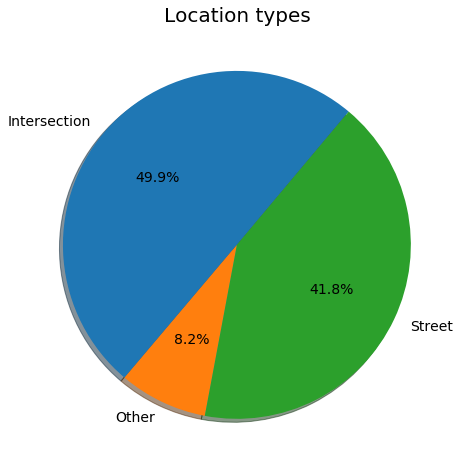

In [12]:
#Visualization
ltype = mydata.groupby('location_type').count()['dispatch_ts']
plt.figure(figsize = (8,8))
plt.pie(ltype,labels = ltype.index,autopct='%1.1f%%',shadow=True, startangle=50,textprops={'fontsize': 14})
plt.title('Location types',fontsize=20)
plt.show()

This graph shows that accidents happen more at street intersections than at street.
It may reflect the fact that there is a higher risk to have accidents at street intersections because people have worse view range and there are more traffic intersections at street intersections.

### 2. The Crash types

This is the crash object types:
1. mv: Moto Vehicle
2. bike: Bike
3. ped: Pedestrian

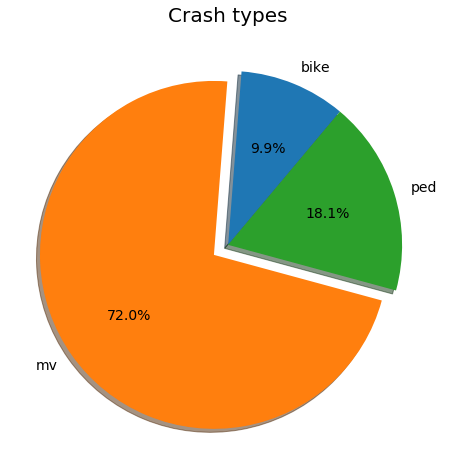

In [13]:
#Visualization
ctype = mydata.groupby('mode_type').count()['dispatch_ts']
plt.figure(figsize = (8,8))
explode = (0, 0.1, 0) #Emphasis the "mv"
plt.pie(ctype,labels = ctype.index,explode = explode,autopct='%1.1f%%',shadow=True, startangle=50,textprops={'fontsize': 14})
plt.title('Crash types',fontsize=20)
plt.show()


This graph shows that most of accidents are moto vehicles. Thus, we can predict that the accident will be related to the weather. As one of the reason, moto vehicles may skid and lose control when raining or snowing.

### 3. Temperature Change
This shows how is the temperature changed from (2015, 1, 1) to (2019, 5, 5) every 30 days.

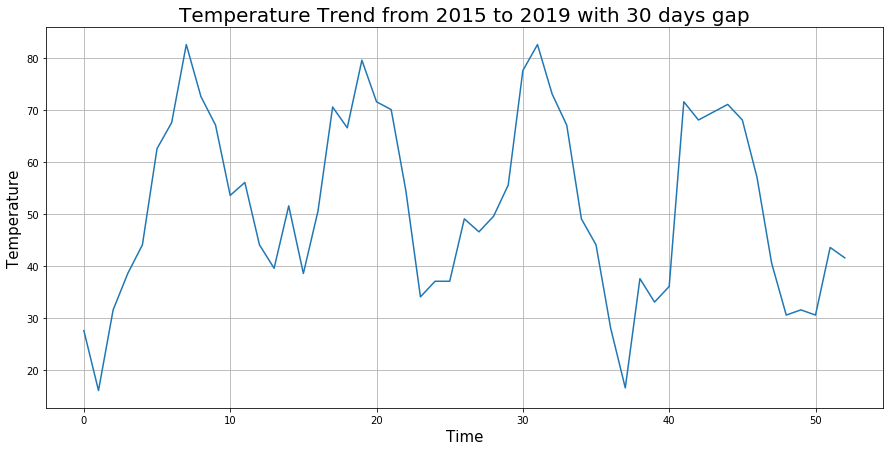

In [14]:
#Visualization
plt.figure(figsize = (15,7))
plt.plot(range(0,len(weather['Avg Temp'][24472::30])),weather['Avg Temp'][24472::30])
plt.grid()
plt.title('Temperature Trend from 2015 to 2019 with 30 days gap',fontsize=20)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Temperature',fontsize=15)
plt.show()

This graph shows that the temperature is periodically changing. Thus, if crashes are related to temperature, the number of crashes is supposed to have periodicity.

### 4. Rain level
This is defined by the amount of water precipitation:
1. No Rain: preciption = 0
2. Drizzle: precition between 0 to 0.01
3. Light rain: precition between 0.01 to 0.1
4. Moderate Rain: precition between 0.1 to 0.25
5. Heavy Rain: precition between 0.25 to 0.5
6. Rain Storm: precition between 0.5 to 1
7. Heavy Rainstorm: precition between 1 to 2
8. Extreme Heavy Rainstorm: precition over 2

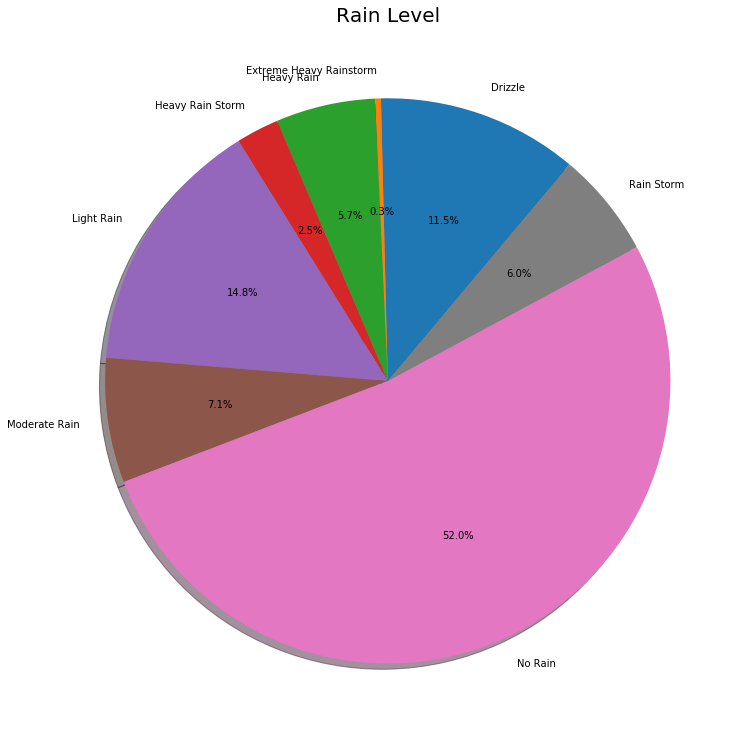

In [15]:
rtype = mydata.groupby('rainlevel').count()['dispatch_ts']
#Visualization
plt.figure(figsize = (13,13))
#explode = (0, 0.1, 0) #Emphasis the "mv"
plt.pie(rtype,labels = rtype.index,autopct='%1.1f%%',shadow=True, startangle=50,textprops={'fontsize': 10})
plt.title('Rain Level',fontsize=20)
plt.show()

This graph shows that accidents are not very related to whether the weather is raining or not. However, it is too early for us to claim that because we haven't consider the probability of raining or not. Thus, we can analyze deeper to find that out later.

# Descriptive Analysis
In this part, we are going to analyze our target question and make conclusions based on what we found.
### 1. What is the relationship between crash & Month with Daytime?

#### The relationship between crash & Daytime
Daytime is defined by the hours of a day:
1. Morning: from 6:00 to 11:59
2. Afternoon: from 12:00 to 16:59
3. Evening: from 17:00 to 20:59
4. Night: from 21:00 to 5:00

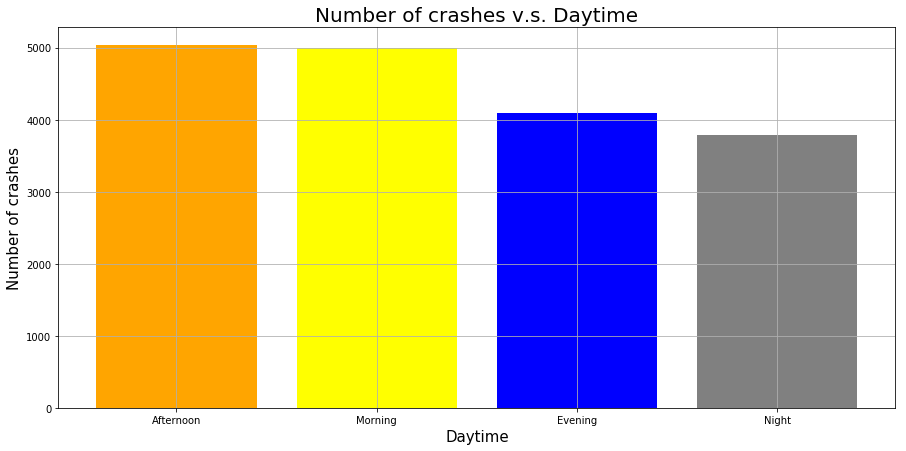

In [16]:
#Visualization
dt = pd.DataFrame(mydata['daytime'].value_counts())

plt.figure(figsize = (15,7))
plt.bar(x = dt.index, height = dt['daytime'], color = ('orange','yellow','blue','grey'))
plt.grid()
plt.title('Number of crashes v.s. Daytime',fontsize=20)
plt.xlabel('Daytime',fontsize=15)
plt.ylabel('Number of crashes',fontsize=15)
plt.show()


This graph shows that there is no obvious difference among different daytimes. However, since we do not have the data of the complete traffic information including both crashes and safe drivings, we cannot go deeper to weight them by the number of cars which were on the road at the specific time. In spite of this, we can still guess that there are less cars on the road at night. Since the number of crashes at night are similar to other daytimes, there may exist higher risk of crashes when driving at night.

Although the daytime information is not very useful in previous graph, we can analyze the pattern between them and the whole through different month. Thus, we can have a clear understanding about how is crashes various in different month with more details.

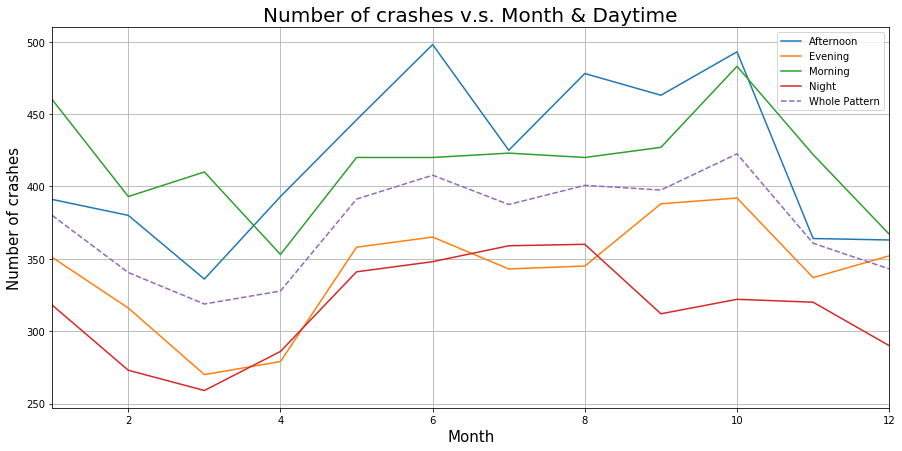

In [17]:
#Visualization
fig, ax = plt.subplots(figsize=(15,7))

mydata.groupby([mydata['dispatch_ts'].dt.month,'daytime']).count()['dispatch_ts'].unstack().plot(kind = 'line',ax = ax)
#In order to make it easier to compare the whole pattern with other 4 daytimes, we devide it by 4.
plt.plot(mydata.groupby(mydata['dispatch_ts'].dt.month).count()['dispatch_ts']/4, linestyle = '--',label = "Whole Pattern")
plt.grid()
plt.legend()
plt.title('Number of crashes v.s. Month & Daytime',fontsize=20)
plt.xlabel('Month',fontsize=15)
plt.ylabel('Number of crashes',fontsize=15)
plt.show()

Conclusion:
Based on this graph, we notice that there are differences among different months: there are less crashes around March but more crashes around July and October. Daytimes also follow this pattern but crashes happend in the afternoon are more fluctuant than others. It is suprising that the number of crashes at night is not the most since we all know that visibility is worst at night. The reason may be there is less car on the road at night even though the crash risk may be higher at night.

### 2. Are crashes related to temperature? Is there a trend?
Let's plot the graph of Temperature v.s. Number of crashes and check whether there is a trend and whether it has periodicity.

In [18]:
#Create target data having number of crashes for each day
Day = pd.DataFrame(mydata.groupby(mydata['new_date']).count()['dispatch_ts'])
Temp = pd.merge(Day, weather[['Avg Temp','new_date']], how='left', on=['new_date'])

In [19]:
#Finde the regression trend line using linear regression model
X = Temp['Avg Temp'].values.reshape(-1, 1)  
Y = Temp['dispatch_ts'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

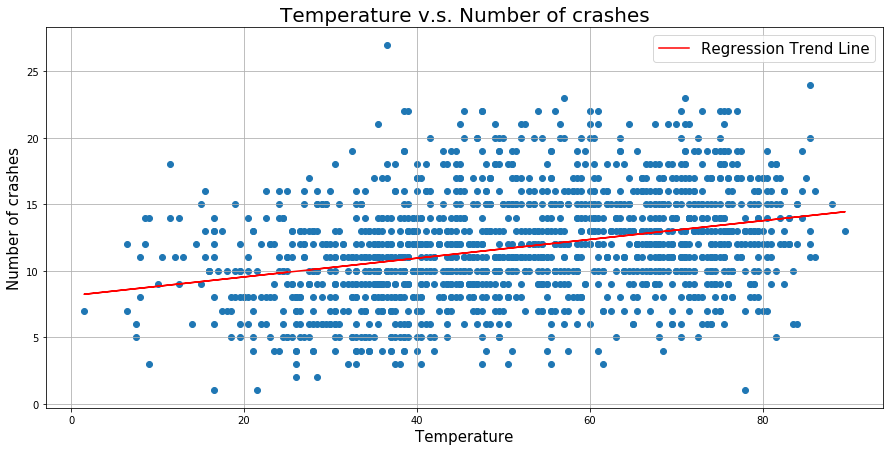

In [21]:
#Visualization
plt.figure(figsize = (15,7))


plt.scatter(Temp['Avg Temp'], Temp['dispatch_ts'],label = None)
plt.plot(X, Y_pred, color='red',label = 'Regression Trend Line')
plt.grid()
plt.legend(fontsize=15)
plt.title('Temperature v.s. Number of crashes',fontsize=20)
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Number of crashes',fontsize=15)
plt.show()

Conclusion:
Based on this graph, we cannot see any periodicity. Also, the slope of trend line is not significantly large. Thus, we can claim that there is no strict relashionship between temperature and crashes.

### 3. How does the rain fall affect the crashes?
Although accidents seems not very related to whether the weather is raining or not, the result may be totally different if we weight it. Here we weight the data by using the rainfall level proportion. It is calculated by (frequency of each rain level/total number of days) in "weather" data. Once we have the the proportion, it refers to the probablility of which rain level may show up in a day. For example, if the proportion of "No rain" is 0.6, then it means that there is 60% change have no rain for every day in general. 

Then, we can weight the number of crashes by (Number of crashes/Proportion) to represent the risk of happening crashes.

In [22]:
#Number of crashes v.s. rainlevel
water = pd.DataFrame(mydata.groupby(['rainlevel']).count()['dispatch_ts'])
water = water.sort_values(by = 'dispatch_ts', ascending = False)

new_weather = weather.copy()
new_weather['rainlevel'] = rainlevel(new_weather['Precipitation Water Equiv'])
water_prop = pd.DataFrame(new_weather.groupby(['rainlevel']).count()['Date']/len(new_weather))

my_rainfall = pd.merge(water, water_prop, how='left', on=['rainlevel'])
my_rainfall.columns = ['Numb of Crashes','Prop']
my_rainfall['risk'] = normalize(my_rainfall['Numb of Crashes']/my_rainfall['Prop']) #normalized risk

In [23]:
#pre-view
my_rainfall

,Numb of Crashes,Prop,risk
rainlevel,,,
No Rain,9321,0.614399,0.085348
Light Rain,2657,0.138575,0.107867
Drizzle,2059,0.036726,0.315404
Moderate Rain,1277,0.071916,0.099895
Rain Storm,1081,0.050848,0.119601
Heavy Rain,1018,0.058677,0.097603
Heavy Rain Storm,439,0.023640,0.104474
Extreme Heavy Rainstorm,60,0.004835,0.069808


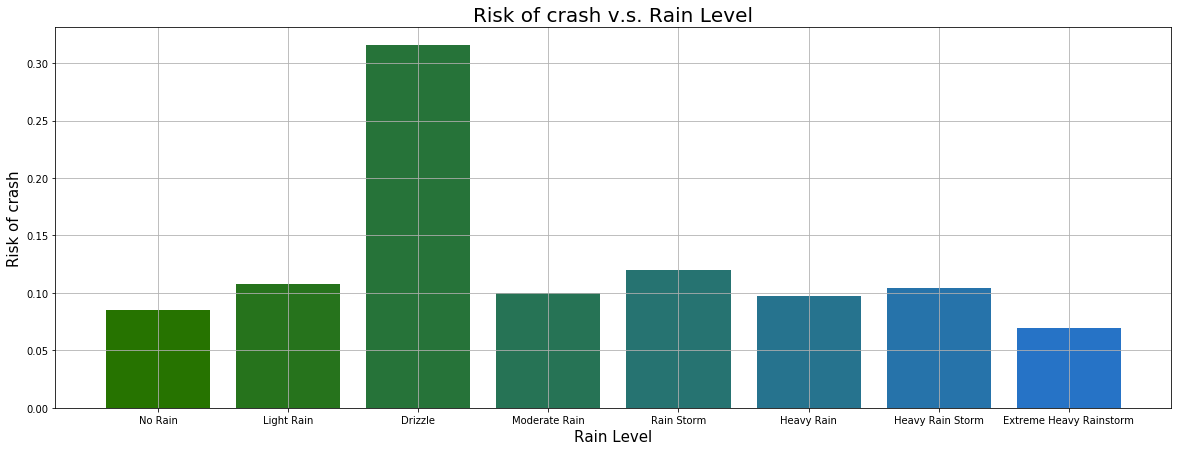

In [24]:
#Visualization
plt.figure(figsize = (20,7))
mycolor = shade( (0.15, 0.45, 0.5),len(my_rainfall),2)

plt.bar(x = my_rainfall['risk'].index, height = my_rainfall['risk'], color = mycolor)
plt.grid()
plt.title('Risk of crash v.s. Rain Level',fontsize=20)
plt.xlabel('Rain Level',fontsize=15)
plt.ylabel('Risk of crash',fontsize=15)
plt.show()

Conclusion:
Based on the graph, the result totally changed. The total risk of driving "In the rain" is about 9 times of the risk of driving with "No Rain". My hypothesis that is proved. However, surprisingly, the rain level "Drizzle" rather than "Extreme Heavy Rainstorm" has the highest risk. I expected to see the trend that "Heavier rain means higher risk". The reason may be that people rarely drive in that extreme weather. When the weather is drizzle, people won't think it is a trouble for them to leave home. However, if the weather is terrible, very few people prefer to leave home so that there will be less cars on the road when the weather is worse. Thus, my advice for drivers is: drive carefully especially when the weather only have a litte rains because comparing to having no rain, the road is sliper and the visibility is lower but the number of cars on the road barely doesn't change.

### 4. Which streets have the highest crash risk?

To analyze the which steets are more dangerous for accidents, we have to find the number of accidents for each streets. However, based on the previous overview of the data, we noticed that there are more than 50% accidencts happend at street intersection. Thus, there are about 10000 streets have NA names because the accident happened at two street's intersection. To solve this problem, I decide to give 0.5 count value to those two streets. For example, if an accident happened at the intersection of BOYLSTON ST and MASSACHUSETTS AVE, I count them 0.5 each. Here I will find out the top 10 streets having the heigher crash risk.

In [25]:
#Divide the data by whether the 'street' column is NA or not.

#NA streets
st1 = pd.DataFrame(mydata.loc[(pd.notna(mydata['street']))].groupby(['street']).count()['dispatch_ts'].sort_values(ascending = False))

#Not NA streets
st2 = pd.DataFrame(mydata.loc[(pd.isna(mydata['street']))].groupby(['xstreet1']).count()['dispatch_ts'].sort_values(ascending = False))
st3 = pd.DataFrame(mydata.loc[(pd.isna(mydata['street']))].groupby(['xstreet2']).count()['dispatch_ts'].sort_values(ascending = False))

#Rename
st1.index.names = ['Street']
st1.columns = ['Crash Numb']
st2.index.names = ['Street']
st2.columns = ['Crash Numb']
st3.index.names = ['Street']
st3.columns = ['Crash Numb']

#Sum the Crash numbers
st4 = (st2.reindex_like(st3).fillna(0)*0.5 + st3.fillna(0).fillna(0)*0.5)
#Target data frame:
st5 = (st4.reindex_like(st1).fillna(0) + st1.fillna(0).fillna(0))
st5['Crash Numb'] = normalize(st5['Crash Numb'])
st5.columns = ['Crash Risk']

In [26]:
print("The average crash risk for every street is: {cn} ".format(cn = round(st5.mean(),10)) )

The average crash risk for every street is: Crash Risk    0.000923
dtype: float64 


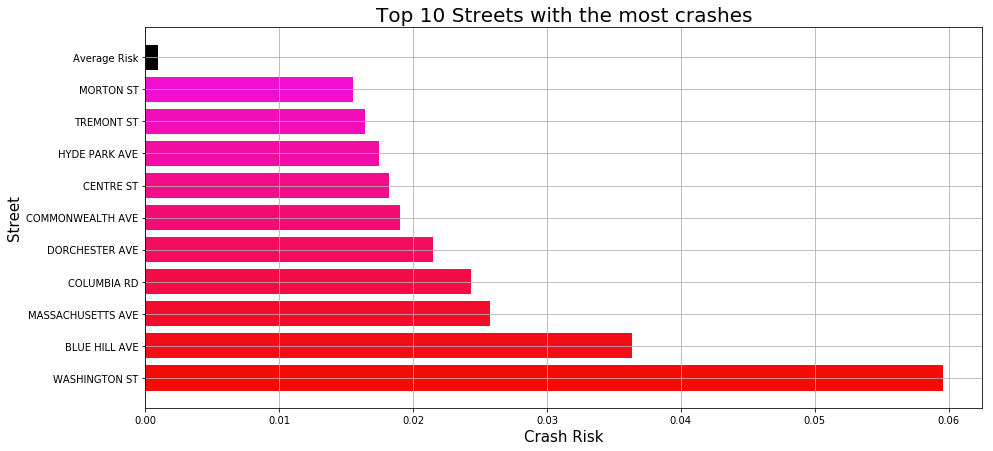

In [27]:
#Visualization
top10 = st5.sort_values(by = 'Crash Risk',ascending = False).head(10)

plt.figure(figsize = (15,7))
mycolor = shade( (0.95, 0.05, 0.5),len(top10),2)
plt.barh(y = top10.index, width = top10['Crash Risk'], color = mycolor)
plt.barh(y = 'Average Risk', width = round(st5.mean(),10), color = 'black')
plt.grid()
plt.title('Top 10 Streets with the most crashes',fontsize=20)
plt.xlabel('Crash Risk',fontsize=15)
plt.ylabel('Street',fontsize=15)
plt.show()

In [28]:
print("The top 10 most dangerous street of having crashes are: \n{car} \nPS: The level is from high to low".format(car = list(top10.index)))

The top 10 most dangerous street of having crashes are: 
['WASHINGTON ST', 'BLUE HILL AVE', 'MASSACHUSETTS AVE', 'COLUMBIA RD', 'DORCHESTER AVE', 'COMMONWEALTH AVE', 'CENTRE ST', 'HYDE PARK AVE', 'TREMONT ST', 'MORTON ST'] 
PS: The level is from high to low


Conclusion: Based on this graph, we noticed that all those 10 streets are much more dangerous than the average risk level. Specially, the Washington St. is the most dangerous street and it is almost 2 times dangerous than the other 9 streets. Thus, my advice for drivers is: driving carefully when you are on those streets. My advice for transport department is: sending more police forces and updating traffic/street/intersection structures of those places to organize them better and reduce the crash hidden danger.

# Predictive Analysis
### 60 Days forecast of number of Crashes
This is the forecast from 2019-03-01 to 2019-04-29 using Holt_Winter exponential smoothing method.
To briefly introduction the Holt_Winter method, it's advantage is that it can using season as a considerable factor.

In [29]:
#Time Serise data
Day.index = pd.to_datetime(Day.index)
Day.columns = ['Numb of Crash']

In [30]:
#Train and test data
train = Day['2018-01-01':'2019-01-01']
test = Day['2019-01-01':]
#Split the data is to directly show the accuracy of the forecast

#Target prediction data
pred = pd.DataFrame(pd.date_range('2019-03-01', periods=60),range(0,60))
pred.index = pd.to_datetime(pd.date_range('2019-03-01', periods=60))


Here we use additive type to both trend and season factor becasue the number of crashes are not growing through time (which means its time series graph looks like a trumpet).

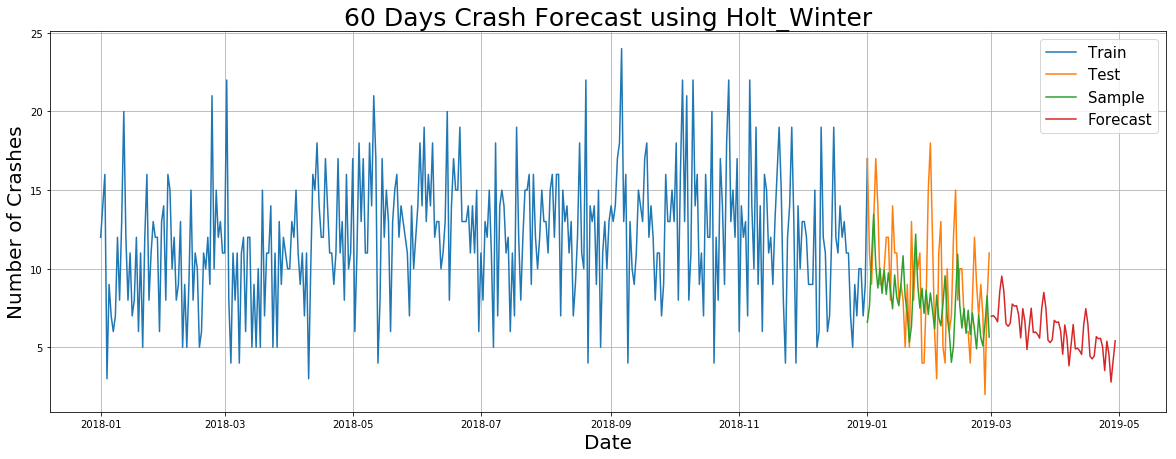

In [31]:
#Visualization
sample = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train['Numb of Crash']), seasonal_periods=20, trend='add', seasonal='add',).fit()
sample['Holt_Winter'] = fit1.forecast(len(test))

fit2 = ExponentialSmoothing(np.asarray(Day['Numb of Crash']), seasonal_periods=20, trend='add', seasonal='add',).fit()
pred['forecast'] = fit2.forecast(len(pred))
plt.figure(figsize=(20,7))
plt.plot( train['Numb of Crash'], label='Train')
plt.plot(test['Numb of Crash'], label='Test')
plt.plot(sample['Holt_Winter'], label='Sample')
plt.plot(pred['forecast'], label='Forecast')
plt.legend(fontsize=15)
plt.grid()
plt.title('60 Days Crash Forecast using Holt_Winter',fontsize=25)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Number of Crashes',fontsize=20)
plt.show()

Conclusion: The sample prediction works fairly well. Thus, the forecasting is somehow convincing. Although the volatility is not perfectly predicted through this method, the forecast shows that the number of crashes are slowly reducing. It is a good news. 